<a href="https://www.kaggle.com/code/andrssebastian/neurips-baseline?scriptVersionId=162112230" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# Importamos los módulos del sistema operativo y de procesos de subcomandos
import os
import subprocess

# Importamos pandas para la manipulación de datos
import pandas as pd

# Importamos PyTorch y sus submódulos para redes neuronales
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision

# Importamos modelos específicos de torchvision
from torchvision.models import resnet18

# Utilidades de PyTorch para el manejo de datos
from torch.utils.data import DataLoader, Dataset

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

## Load Data

In [2]:
def load_example(df_row):
    image = torchvision.io.read_image(df_row['image_path'])
    result = {
        'image': image,
        'image_id': df_row['image_id'],
        'age_group': df_row['age_group'],
        'age': df_row['age'],
        'person_id': df_row['person_id']
    }
    return result

class HiddenDataset(Dataset):
    def __init__(self, split='train'):
        super().__init__()
        self.examples = []

        df = pd.read_csv(f'/kaggle/input/neurips-2023-machine-unlearning/{split}.csv')
        df['image_path'] = df['image_id'].apply(
            lambda x: os.path.join('/kaggle/input/neurips-2023-machine-unlearning/', 'images', x.split('-')[0], x.split('-')[1] + '.png'))
        df = df.sort_values(by='image_path')
        df.apply(lambda row: self.examples.append(load_example(row)), axis=1)
        if len(self.examples) == 0:
            raise ValueError('No examples.')

    def __len__(self):
        return len(self.examples)

    def __getitem__(self, idx):
        example = self.examples[idx]
        image = example['image']
        image = image.to(torch.float32)
        example['image'] = image
        return example
    
def get_dataset(batch_size):
    retain_ds = HiddenDataset(split='retain')
    forget_ds = HiddenDataset(split='forget')
    val_ds = HiddenDataset(split='validation')

    retain_loader = DataLoader(retain_ds, batch_size=batch_size, shuffle=True)
    forget_loader = DataLoader(forget_ds, batch_size=batch_size, shuffle=True)
    validation_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=True)

    return retain_loader, forget_loader, validation_loader

## Unlearning GAN

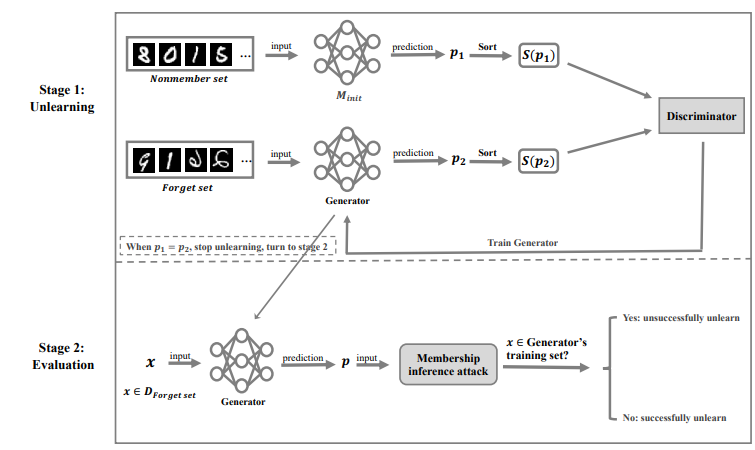

Chen, K., Huang, Y., & Wang, Y. (2021). Machine unlearning via GAN. arXiv. Retrieved from [arxiv.org](https://arxiv.org/abs/2111.11869).

In [3]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(10, 512), # Vector de 10 claes como entrada a la red
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        return self.model(x)

In [4]:
def unlearning(generator, discriminator, feature_extractor, retain_loader, forget_loader, validation_loader): 
    epochs = 50
    
    criterion = nn.BCEWithLogitsLoss()
    
    #optimizer_discriminator = optim.Adam(discriminator.parameters(), lr=0.0002)
    #optimizer_generator = optim.Adam(generator.parameters(), lr=0.0002)
    optimizer_generator = optim.SGD(generator.parameters(), lr=0.001, momentum=0.9, weight_decay=5e-4)
    scheduler_generator = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer_generator, T_max=epochs)
    
    optimizer_discriminator = optim.SGD(discriminator.parameters(), lr=0.001, momentum=0.9, weight_decay=5e-4)
    scheduler_discriminator = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer_discriminator, T_max=epochs)

    discriminator.train()
    generator.train()
    
    for epoch in range(epochs):
        for retain_data, forget_data in zip(retain_loader, forget_loader):
            retain_inputs, retain_labels = retain_data["image"], retain_data["age_group"]    
            forget_inputs, forget_labels = forget_data["image"], forget_data["age_group"]
            
            retain_inputs, retain_labels = retain_inputs.to(DEVICE), retain_labels.to(DEVICE)
            forget_inputs, forget_labels = forget_inputs.to(DEVICE), forget_labels.to(DEVICE)

            # Actualiza el discriminador con datos para retener
            optimizer_discriminator.zero_grad()
            # No es necesario calcular gradientes para el feature_extractor
            retain_features = feature_extractor(retain_inputs).detach()
            retain_predictions = discriminator(retain_features)
            retain_loss = criterion(retain_predictions, torch.ones_like(retain_predictions))
            
            # Actualiza el discriminador con datos para olvidar
            forget_features = generator(forget_inputs).detach() # Asegura que no afectamos al generador
            forget_predictions = discriminator(forget_features)
            forget_loss = criterion(forget_predictions, torch.zeros_like(forget_predictions))
            
            # Pérdida y actualización del discriminador
            discriminator_loss = retain_loss + forget_loss
            # Retener la información necesaria (gradientes) para calcular los gradientes del generador
            # Cómo las salidas han engañado al discriminador
            discriminator_loss.backward(retain_graph = True)
            optimizer_discriminator.step()
            
            # Actualiza el generador
            optimizer_generator.zero_grad()
            # Genera de nuevo, ya que el grafo anterior (No es necesario retener el grafo) fue liberado después de la actualización del discriminador
            forget_features = generator(forget_inputs)
            generator_predictions = discriminator(forget_features)
            generator_loss = criterion(generator_predictions, torch.ones_like(generator_predictions))
            generator_loss.backward()
            optimizer_generator.step()
            
        scheduler_generator.step()
        scheduler_discriminator.step()
           
    discriminator.eval()
    generator.eval()

In [5]:
if os.path.exists('/kaggle/input/neurips-2023-machine-unlearning/empty.txt'):
    subprocess.run('touch submission.zip', shell = True)
else:
    os.makedirs('/kaggle/tmp', exist_ok = True)
    retain_loader, forget_loader, validation_loader = get_dataset(64)
    generator = resnet18(weights = None, num_classes = 10)
    feature_extractor = resnet18(weights = None, num_classes = 10)
    discriminator = Discriminator()
    generator.to(DEVICE)
    discriminator.to(DEVICE)
    feature_extractor.to(DEVICE)
    for i in range(512):
        generator.load_state_dict(torch.load('/kaggle/input/neurips-2023-machine-unlearning/original_model.pth'))
        unlearning(generator, discriminator, feature_extractor, retain_loader, forget_loader, validation_loader)
        state = generator.state_dict()
        torch.save(state, f'/kaggle/tmp/unlearned_checkpoint_{i}.pth')

    unlearned_ckpts = os.listdir('/kaggle/tmp')
    if len(unlearned_ckpts) != 512:
        raise RuntimeError('Expected exactly 512 checkpoints. The submission will throw an exception otherwise.')
        
    subprocess.run('zip submission.zip /kaggle/tmp/*.pth', shell = True)